In [1]:
import numpy as np
from numba import jit
import os, sys
sys.path.append("../src")
from utils import colormaps

In [2]:
@jit(nopython = True)
def boardify(board, zero_first = True): 
    board = board.copy()
    nrows, ncols = board.shape
    for i in range(nrows):
        for j in range(i + 1, ncols):
            board[i, j] = 0
    if zero_first: 
        board[0, 0] = 0
    return board

@jit(nopython=True)
def resample_board(board, q, minrow = 0):
    resampled = board.copy()
    for i in range(minrow, board.shape[0]): 
        for j in range(i + 1):
            if np.random.random() < q: 
                resampled[i, j] = np.random.randint(1, 10)
    return resampled

@jit(nopython = True)
def make_board(p_unreliable = 0, p_volatile = 0, p_transition = 0, n = 8):
    # Initialize arrays
    oracle = np.zeros((n, n), dtype=np.int64)
    boards = np.zeros((n, n, n), dtype=np.int64)
    
    # Initialize reliability and volatility tracking arrays
    is_unreliable = np.zeros((n, n), dtype=np.bool_)
    is_volatile = np.zeros((n, n, n), dtype=np.bool_)
    is_transition = np.zeros((n-1), dtype=np.bool_)
    
    # Initialize first board
    boards[0] = boardify(np.random.randint(1, 10, (n, n)))
    
    # Generate boards over time (trial t, row r, column c)
    for r in range(1, n):
        for c in range(r + 1):
            for t in range(1, n):
                # Volatile elements randomly change their value
                # Only elements in row r >= t are eligible to be volatile
                if np.random.random() < p_volatile and r >= t:
                    is_volatile[t, r, c] = True
                    boards[t, r, c] = np.random.randint(1, 10)
                else:
                    # Non-volatile elements keep previous value
                    is_volatile[t, r, c] = False
                    boards[t, r, c] = boards[t - 1, r, c]
            
            # Final value of element (r, c) is its true value
            oracle[r, c] = boards[n-1, r, c]
            
            # Apply unreliability to oracle
            if np.random.random() < p_unreliable:
                oracle[r, c] = np.random.randint(1, 10)
                is_unreliable[r, c] = True
        
        # Apply transition probability
        if np.random.random() < p_transition:
            is_transition[r-1] = True
    
    return boards, oracle, is_unreliable, is_volatile, is_transition


@jit(nopython = True)
def get_pov(board, row, col):
    pov_board = np.zeros_like(board)
    pov_board[:board.shape[0] - row, :board.shape[1] - col] = boardify(board[row:, col:], zero_first = False)
    return pov_board

@jit(nopython=True)
def filter_depth(pov_array, depth):
    filtered_array = np.where(np.arange(pov_array.shape[0])[:, None] <= depth, pov_array, 0)
    return filtered_array

@jit(nopython=True)
def value_path(pov_array, variant=None, value_params=None):
    values = pov_array.copy()
    table = np.zeros_like(values, dtype=np.float64)
    table[-1] = values[-1]

    for row in range(len(values)-2, -1, -1):
        for col in range(row + 1):
            table[row, col] = values[row, col] + max(table[row+1, col], table[row+1, col+1])

    v_left = table[1, 0]
    v_right = table[1, 1]
    v_diff = v_left - v_right
    
    return v_diff

@jit(nopython=True)
def sim(boards, oracle, is_transition, depth=1, beta=20):
    row, col = 0, 0
    reward = 0
    
    for t in range(len(boards) - 1):
        board = boards[t]
        swap_move = is_transition[t]

        reward += oracle[row, col]
        board_pov = get_pov(board, row, col)
        filter_board = filter_depth(board_pov, depth)
        
        delta = value_path(filter_board)
        p_left = 1/(1 + np.exp(-beta * delta))
        is_left = np.random.random() < p_left

        if swap_move:
            is_left = not is_left

        if is_left:
            row, col = row + 1, col
        else: 
            row, col = row + 1, col + 1
            
    reward += oracle[row, col]
    return reward


In [25]:
import matplotlib.pyplot as plt

q_reliabilities = np.array([0, 0.25, 0.5, 0.75, 1])
q_volatilities = np.array([0, 0.25, 0.5, 0.75, 1])
q_controllabilities = np.array([0, 0.125, 0.25, 0.375, 0.5])
depths = [0, 1, 2, 3, 4, 5, 6, 7]
n_trials = 10000

@jit(nopython=True)
def run_simulations(q_reliabilities, q_volatilities, q_controllabilities, depths, n_trials):
    # Pre-allocate arrays for each parameter type
    rewards_reliability = np.zeros((len(q_reliabilities), n_trials, len(depths)))
    rewards_volatility = np.zeros((len(q_volatilities), n_trials, len(depths))) 
    rewards_controllability = np.zeros((len(q_controllabilities), n_trials, len(depths)))
    
    # Run simulations for reliability
    for i, q in enumerate(q_reliabilities):
        for j in range(n_trials):
            boards, oracle, is_unreliable, is_volatile, is_transition = make_board(p_unreliable=q)
            for k, d in enumerate(depths):
                rewards_reliability[i, j, k] = sim(boards, oracle, is_transition, depth=d)

    # Run simulations for volatility                
    for i, q in enumerate(q_volatilities):
        for j in range(n_trials):
            boards, oracle, is_unreliable, is_volatile, is_transition = make_board(p_volatile=q)
            for k, d in enumerate(depths):
                rewards_volatility[i, j, k] = sim(boards, oracle, is_transition, depth=d)

    # Run simulations for controllability
    for i, q in enumerate(q_controllabilities):
        for j in range(n_trials):
            boards, oracle, is_unreliable, is_volatile, is_transition = make_board(p_transition=q)
            for k, d in enumerate(depths):
                rewards_controllability[i, j, k] = sim(boards, oracle, is_transition, depth=d)
                    
    return rewards_reliability, rewards_volatility, rewards_controllability


def compute_optimal_depths(qs, rewards_data, n_participants=100, n_samples_per_participant=100):
    # Remove jit since np.random.choice isn't supported in nopython mode
    opt_depths = np.zeros((n_participants, len(qs), n_samples_per_participant))
    rewards_means = rewards_data.mean(axis=1)
    
    for i in range(n_participants):
        for j, (q, rewards) in enumerate(zip(qs, rewards_means)):
            coef = np.random.normal(0.3, 0.15)
            costs = coef * np.arange(8) ** 2
            utilities = rewards - costs
            exp_utilities = np.exp((utilities - utilities.min()))
            softmax_utilities = exp_utilities / exp_utilities.sum()
            for k in range(n_samples_per_participant):
                max_idx = np.random.choice(len(utilities), p=softmax_utilities)
                opt_depths[i, j, k] = max_idx
    return opt_depths

rewards_data_reliability, rewards_data_volatility, rewards_data_controllability = run_simulations(q_reliabilities, q_volatilities, q_controllabilities, depths, n_trials)
opt_depths_reliability = compute_optimal_depths(q_reliabilities, rewards_data_reliability)
opt_depths_volatility = compute_optimal_depths(q_volatilities, rewards_data_volatility)
opt_depths_controllability = compute_optimal_depths(q_controllabilities, rewards_data_controllability)


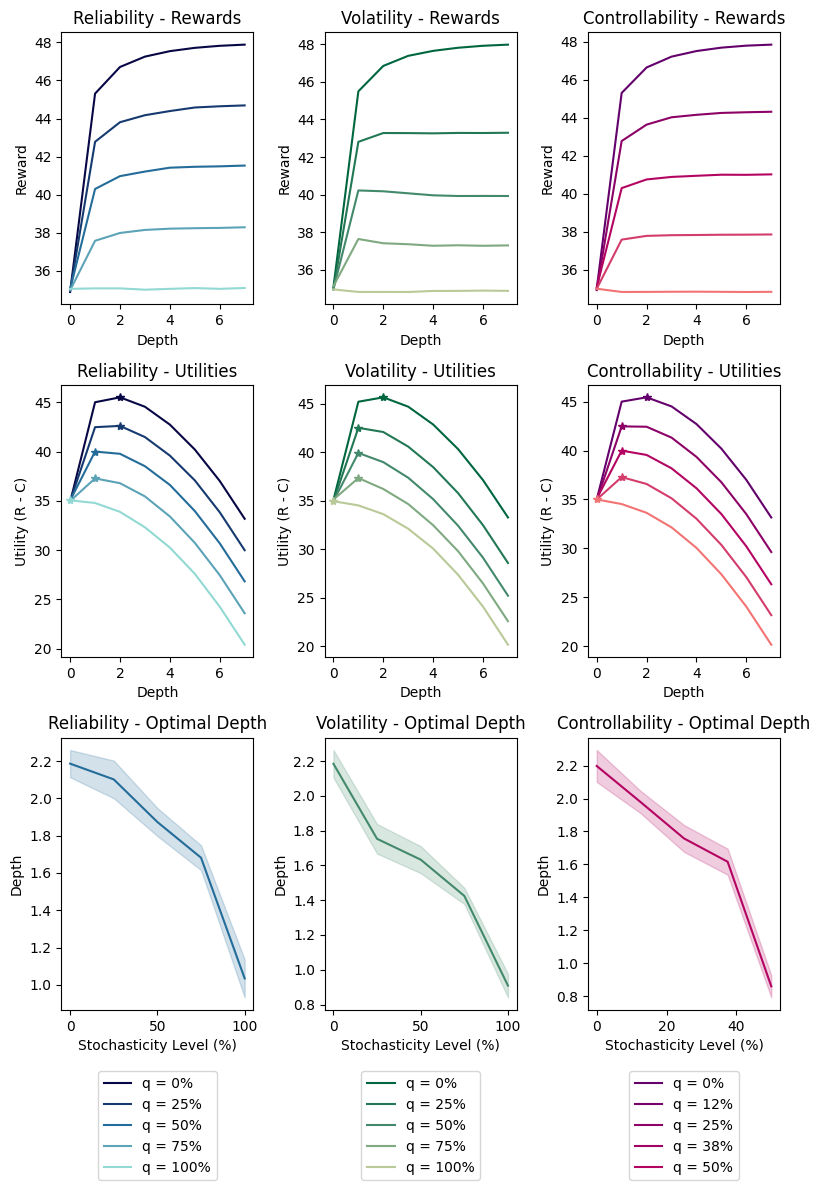

In [26]:
if not os.path.exists("figures/resource_rationality"):
    os.makedirs("figures/resource_rationality")

def plot_resource_rationality_results(qs_list, depths, rewards_data_list, opt_depths_list, colormap_list, titles):
    from matplotlib.lines import Line2D
    fig, axes = plt.subplots(3, 3, figsize=(8, 12))

    for col, (qs, rewards_data, opt_depths, colormap, title) in enumerate(zip(qs_list, rewards_data_list, opt_depths_list, colormap_list, titles)):
        # Plot rewards vs depth for different reliabilities
        for q, rewards in zip(qs, rewards_data.mean(axis=1)):
            axes[0,col].plot(depths, rewards, color=colormap(q / np.max(qs)))
        axes[0,col].set_xlabel('Depth')
        axes[0,col].set_ylabel('Reward')
        axes[0,col].set_title(f'{title} - Rewards')

        # Plot utilities (rewards - costs) vs depth
        for q, rewards in zip(qs, rewards_data.mean(axis=1)):
            costs = 0.3 * np.arange(0, 8) ** 2
            utilities = rewards - costs
            axes[1,col].plot(depths, utilities, color=colormap(q / np.max(qs)))
            max_idx = np.argmax(utilities)
            axes[1,col].plot(depths[max_idx], utilities[max_idx], '*', color=colormap(q / np.max(qs)))
        axes[1,col].set_xlabel('Depth')
        axes[1,col].set_ylabel('Utility (R - C)')
        axes[1,col].set_title(f'{title} - Utilities')

        # Plot optimal depth vs stochasticity with error bands
        # First take mean across k samples for each participant
        opt_depths_mean_k = opt_depths.mean(axis=2)  # i,j
        # Then get mean and sem across participants
        participant_means = opt_depths_mean_k.mean(axis=0)  # j
        participant_sem = opt_depths_mean_k.std(axis=0) / np.sqrt(opt_depths_mean_k.shape[0])  # j
        
        axes[2,col].plot(qs * 100, participant_means, color=colormap(0.5))
        axes[2,col].fill_between(qs * 100,
                         participant_means - participant_sem,
                         participant_means + participant_sem,
                         alpha=0.2, color=colormap(0.5))
        axes[2,col].set_xlabel('Stochasticity Level (%)')
        axes[2,col].set_ylabel('Depth')
        axes[2,col].set_title(f'{title} - Optimal Depth')

        # Add legend
        legend_elements = [Line2D([0], [0], color=colormap(q), label=f'q = {q*100:.0f}%')
                         for q in qs]
        axes[2,col].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.2), loc='upper center')

    plt.tight_layout()

# Plot all results in a single figure
qs_list = [q_reliabilities, q_volatilities, q_controllabilities]
rewards_data_list = [rewards_data_reliability, rewards_data_volatility, rewards_data_controllability]
opt_depths_list = [opt_depths_reliability, opt_depths_volatility, opt_depths_controllability]
colormap_list = [colormaps["arctic"], colormaps["grass"], colormaps["berry"]]
titles = ["Reliability", "Volatility", "Controllability"]

plot_resource_rationality_results(qs_list, depths, rewards_data_list, opt_depths_list, colormap_list, titles)
plt.savefig("figures/resource_rationality/combined_results.png", bbox_inches='tight')